In [100]:
import math
import os
import sqlite3
import sys
from pathlib import Path
from typing import Literal, cast

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from mxlpy import Model, Simulator, make_protocol, scan
from scipy.signal import find_peaks, peak_prominences

sys.path.append(os.path.abspath('..'))

from model import Matuszynska2016

here = Path("").absolute()

def save_fig(fig_num: str) -> Path:
    here = Path("").absolute()
    name = "Matuszynska2016"
    plt.savefig(here / f"{name.lower()}_fig{fig_num}.svg", format="svg", bbox_inches="tight")

## Str Dictionary

In [101]:
pfd_str = "pfd"
fluorescence_str = "Fluo"
phlumen_str = "pH_lu"
zx_str = "Zx"
psbsp_str = "PsbSP"
quencher_str = "Q"

# kcyc_str = "kf_v_Cyc"
# v_psi_str = "v_PSI"
# v_psii_str = "v_PSII"
# v_cyc_str = "v_Cyc"
# v_mehler_str = "v_Mehler"
# v_ptox_str = "v_PQ"
# atp_rel_str = "ATP/tot"
# nadph_rel_str = "NADPH/tot"
# fd_rel_str = "Fd_ox/tot"
# pq_rel_str = "PQ_ox/tot"
# pc_rel_str = "PC_ox/tot"
# h2o2_str = "H2O2"
# vc_str = "v_RuBisCO_c"
# psii_tot_str = "PSII_total"
# psi_tot_str = "PSI_total"
# kb6f_str = "kcat_v_b6f"
# kMehler_str = "kMehler"
# krubisco_str = "kcat_v_RuBisCO_c"
# kfbpase_str = "kcat_v_FBPase"
# ksbpase_str = "kcat_v_SBPase"
# kmdareduct_str = "kcat_v_MDAreduct"
# kdhar_str = "kcat_v_DHAR"
# pqred_str = "PQH_2"
# fdred_str = "Fd_red"
# pcred_str = "PC_red"
# nadph_str = "NADPH_st"
# atp_str = "ATP_st"
# rubp_str = "RUBP"
# pga_str = "PGA"
# fbp_str = "FBP"
# sbp_str = "SBP"
# vb6f_str = "v_b6f"
# vMehler_str = "v_Mehler"
# v_fbpase_str = "v_FBPase"
# v_sbpase_str = "v_SBPase"
# v_mdareduct_str = "v_MDAreduct"
# v_dhar_str = "v_DHAR"

# Helper functions

In [102]:
def cpfd(species: Literal["Arabidopsis", "Pothos"], PFD: float) -> float:
    """
    converts the given light intensity into internal activation rate
    calibrated for 3 light intensities for two species
    """
    if species == "Arabidopsis":
        light =  0.0005833 * PFD**2 + 0.2667 * PFD + 187.5
    elif species == "Pothos":
        light = 0.0004167 * PFD**2 + 0.3333 * PFD + 862.5

    return light

def phase_intervals_linear(
    phase_duration,
    step,
    first_interval = 0,
    num_steps = None,
    last_intervall = None
):
    phase = []
    accumulated_time = 0
    current_time = first_interval
    
    while accumulated_time < phase_duration and (num_steps is None or len(phase) < num_steps):
        accumulated_time += current_time
        if accumulated_time < phase_duration:
            phase.append(current_time)
        current_time = step * len(phase) + first_interval
        
    if last_intervall is not None:
        phase.append(phase_duration - last_intervall - sum(phase))
        if last_intervall != 0:
            phase.append(last_intervall)
    
    return phase

def prepare_experimental_data(
    data: pd.DataFrame,
    species: Literal["Arabidopsis", "Pothos"],
    pfds: list,
    darkdurations: list
):
    df = data[data.Specie == species].copy()
    
    res = {}
    for lightintensity, darkduration in zip(pfds, darkdurations):
        df_li = df[df.LightIntensity == lightintensity].copy()
        df_li_dd = df_li[df_li.DarkDuration == darkduration].copy()
        df_li_dd['Time'] = pd.to_timedelta(df_li_dd['Time'])
        
        replicates = []
        
        for replic in [1, 2, 3]:
            df_li_dd_replic = df_li_dd[df_li_dd['Replicate'] == replic].copy()
            
            df_li_dd_replic['Timedelta'] = (df_li_dd_replic['Time'] - df_li_dd_replic['Time'].iloc[0]).apply(lambda x: x.total_seconds())
            df_li_dd_replic['Fm_rel'] = (df_li_dd_replic['Fm'] / df_li_dd_replic['Fm'].iloc[0])
            df_li_dd_replic['Ft_rel'] = (df_li_dd_replic['Ft'] / df_li_dd_replic['Fm'].iloc[0])
            df_li_dd_replic['Yield'] = df_li_dd_replic['Yield']
            
            replicates.append(df_li_dd_replic)

        df_li_dd = pd.concat(replicates)
        df_li_dd_mean = df_li_dd[['Timedelta', 'Fm_rel', 'Ft_rel', 'Yield', 'ExpId']].groupby('ExpId').agg({'Timedelta': 'mean', 'Fm_rel': ['mean', 'std'], 'Ft_rel': ['mean', 'std'], 'Yield': 'mean'})
        df_li_dd_mean.columns = ['Timedelta_mean','Fm_rel_mean', 'Fm_rel_std','Ft_rel_mean', 'Ft_rel_std', 'Yield_mean']
        
        res[lightintensity] = df_li_dd_mean

    return res

def npq(
    fluo_results: pd.Series,
    peak_distance: float = 30
):
    
    fluo_results = fluo_results / fluo_results.max()
    
    # Find the Flourescence peaks (Fmaxs)
    peaks, _ = find_peaks(fluo_results, distance=peak_distance, height=0)
    
    # Get time at peaks
    time = fluo_results.iloc[peaks].index
    
    # Get Fm
    Fm = fluo_results.iloc[peaks].values
    
    # Calculate NPQ
    NPQ = (Fm[0] - Fm) / Fm
    
    # Find the minima around the peaks
    prominences, prominences_left, prominences_right = peak_prominences(
                (fluo_results), peaks
            )  
    
    # Fo is always the minima before the peak
    Fo = fluo_results.iloc[prominences_left].values
    
    # Maximum quantum yield of PSII (Fv/Fm)
    QY_PSII = (Fm - Fo) / Fm
    
    return time, fluo_results, Fm, NPQ, Fo, QY_PSII

In [103]:
cnx = sqlite3.connect(here /"paperdata_new.db")

cur = cnx.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

df = pd.read_sql_query("select * from LIGHTMEMORY", cnx)
print(df.columns)
columns_to_keep = ['ExpId', 'Fm', 'Specie', 'LightIntensity', 'DarkDuration', 'Time', 'Replicate', 'Ft', 'Yield']
df = df.drop(columns=[i for i in df.columns if i not in columns_to_keep])

fig4_data = prepare_experimental_data(df, "Arabidopsis", [100, 300, 900], [15, 30, 60])
fig6_data = prepare_experimental_data(df, "Pothos", [100], [15])

Index(['ID', 'nrExp', 'filename', 'Specie', 'LightDuration', 'DarkDuration',
       'LightIntensity', 'Replicate', 'Date', 'Time', 'ExpId',
       'MeasuringLight', 'Temperature', 'PAR', 'Ft', 'ETR', 'Yield', 'qP',
       'qN', 'Fm', 'F0', 'V'],
      dtype='str')


# Figure 4

In [104]:
def create_fig4_sim(
    model: Model,
    pfd_str: str
) -> tuple[pd.DataFrame, pd.Series]:
    phase_1 = [30]
    phase_two = phase_intervals_linear(14*60, 20, 30)
    phase_four = phase_intervals_linear(5*60, 20, 30, last_intervall=0)
    
    sp_len = 0.8
    sp_val = 5000
    
    full_res = {}
    full_prtc = {}
    
    for pfd, phase_three_len in zip([100, 300, 900], [15, 30, 60]):
        phase_three = phase_intervals_linear(phase_three_len*60, 20, 30, num_steps=5, last_intervall=30)
        phase_prtc = []
        for phases, pfd_val in zip([phase_1, phase_two, phase_three, phase_four], [0, cpfd("Arabidopsis", pfd), 0, cpfd("Arabidopsis", pfd)], strict=False):
            for time in phases:
                phase_prtc.append((sp_len, {pfd_str: sp_val}))
                phase_prtc.append((time - sp_len, {pfd_str: pfd_val}))
        phase_prtc.append((5*60, {pfd_str: cpfd("Arabidopsis", pfd)}))
        
        pam_prtc = make_protocol(phase_prtc)
        s = Simulator(model)
        s.simulate_protocol(pam_prtc, time_points_per_step=1000)
        full_res[pfd] = s.get_result().unwrap_or_err().get_combined()
        full_prtc[pfd] = pam_prtc

    return pd.concat(full_res, names=[pfd_str], axis=0), pd.concat(full_prtc, names=[pfd_str], axis=0)

def create_fig4_plot(
    res: pd.DataFrame,
    prtc: pd.Series,
    data: dict[int, pd.DataFrame],
    pfd_str: str,
    fluorescence_str: str
):
    fig, axs = plt.subplots(ncols=3, figsize=(15, 3))

    box_height = 0.15
    border_width = 0.01

    for ax, pfd in zip(axs, res.index.levels[0]):
        this_res = res.loc[pfd]
        ax.plot(this_res[fluorescence_str] / max(this_res[fluorescence_str]), color="#db85d8", label="Simulated trace")
        
        pam_ptrc_peaks = prtc.loc[pfd][prtc.loc[pfd][pfd_str] == 5000]
        peaks_times = pd.Series(pam_ptrc_peaks.index).apply(lambda x: x.total_seconds())
        ax.errorbar(peaks_times, data[pfd]["Fm_rel_mean"][:-1], yerr=data[pfd]['Fm_rel_std'][:-1], marker="^", color="black", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_M^'}$ measured", markersize=3.5)
        ax.errorbar(peaks_times, data[pfd]["Ft_rel_mean"][:-1], yerr=data[pfd]['Ft_rel_std'][:-1], marker="^", color="#0071ad", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_S}$ measured", markersize=3.5)
        
        xmin = -60
        if pfd == 100:
            ax.set_xlim(xmin, 36*60)
            ax.set_xticks([i*60 for i in [0, 14, 30, 35]], labels=[0, 14, 30, 35])
        elif pfd == 300:
            ax.set_xlim(xmin, 51*60)
            ax.set_xticks([i*60 for i in [0, 14, 45, 50]], labels=[0, 14, 45, 50])
        else:
            ax.set_xlim(xmin, 81*60)
            ax.set_xticks([i*60 for i in [0, 14, 75, 80]], labels=[0, 14, 75, 80])
        
        ax.set_ylim(0, 1.01)
        ax.set_yticks(np.linspace(0, 1, 6))
        
        cleaned_prtc = prtc.loc[pfd][prtc.loc[pfd][pfd_str] != 5000]
        rect_coords = []
        for idx, val in cleaned_prtc.iterrows():
            if val[pfd_str] == 0:
                color="black"
            else:
                color="white"
            
            new_x = min(idx.total_seconds(), ax.get_xlim()[1])
            if rect_coords == []:
                rect_coords.append({"color": color, "start": xmin, "end": new_x})
            elif rect_coords[-1]["color"] == color:
                rect_coords[-1]["end"] = new_x
            else:
                prior_idx = rect_coords[-1]["end"]
                rect_coords.append({"color": color, "start": prior_idx, "end": new_x})
        
        for i, rect in enumerate(rect_coords):
            box = ax.add_patch(Rectangle(
                (rect["start"], ax.get_ylim()[-1]),
                width=abs(rect["end"] - rect["start"]),
                height=box_height,
                facecolor = rect["color"],
                edgecolor="black",
                clip_on=False
            ))
            
            if i == 1:
                xcoord = box.xy[0] + box.get_width() / 2
                ycoord = box.xy[1] + box.get_height() / 2
                text = f"{pfd} μE m$^{{-2}}$ s$^{{-1}}$" if pfd == 100 else f"{pfd}"
                ax.text(xcoord, ycoord, text, ha="center", va="center", weight="bold")
            
            if i == 2:
                xcoord = box.xy[0] + box.get_width() / 2
                ycoord = box.xy[1] + box.get_height() / 2
                ax.text(xcoord, ycoord, f"{math.ceil(box.get_width()/60)} min", ha="center", va="center", weight="bold", color="white")
                
        ax.set_xlabel("Time (min)")

    axs[0].set(
        ylabel=r"Fluorescence ($\mathrm{F_M^'}$ / $\mathrm{F_M}$)",
    )

    handles, labels = axs[0].get_legend_handles_labels()

    fig.legend(handles, labels, ncols=3, loc="lower center", shadow=True, framealpha=1, edgecolor="black", bbox_to_anchor=(0.5, 0.05))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.35)
    
    return fig, axs

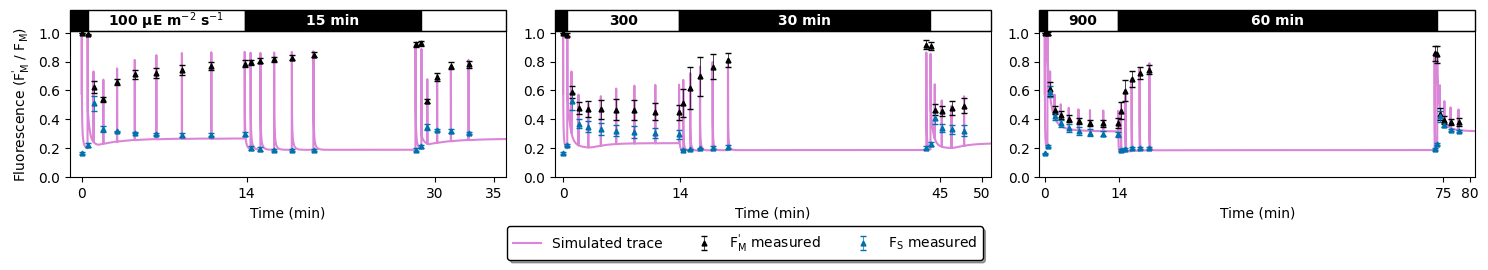

In [105]:
fig4_res, fig4_prtc = create_fig4_sim(
    model=Matuszynska2016(),
    pfd_str=pfd_str
)

create_fig4_plot(
    res=fig4_res,
    prtc=fig4_prtc,
    data=fig4_data,
    pfd_str=pfd_str,
    fluorescence_str=fluorescence_str
)

save_fig("4")

# Figure 5

In [106]:
def create_fig5_sim(
    model: Model,
    pfd_str: str
) -> tuple[dict, pd.DataFrame]:
    final_res = {}
    prtc_res = {}
    
    time_changes = [30, 870, 1830, 2130]
    time_steps = [time_changes[i] - time_changes[i-1] if i > 0 else time_changes[i] for i in range(len(time_changes))]
    
    final_res = {
        "time_sim": {},
        "scan": {}
    }
    
    for pfd in [100, 300, 900]:
        prtc = make_protocol([
            (time_steps[0], {pfd_str: 0}),
            (time_steps[1], {pfd_str: cpfd("Arabidopsis", pfd)}),
            (time_steps[2], {pfd_str: 0}),
            (time_steps[3], {pfd_str: cpfd("Arabidopsis", pfd)}),
        ])
        
        s = Simulator(model)
        s.simulate_protocol(prtc, time_points_per_step=1000)
        final_res["time_sim"][pfd] = s.get_result().unwrap_or_err().get_combined()
        prtc_res[pfd] = prtc
    
    steady_state = scan.steady_state(
        model=model,
        to_scan=pd.DataFrame({pfd_str: np.unique(np.sort(np.concatenate((np.linspace(0, 1000, 50), [100, 300, 900]))))})
    )
    
    final_res["scan"] = steady_state.combined
    
    final_res["time_sim"] = pd.concat(final_res["time_sim"], names=[pfd_str], axis=0)
    prtc_res = pd.concat(prtc_res, names=[pfd_str], axis=0)
    
    return final_res, prtc_res

def create_fig5_plot(
    res: pd.DataFrame,
    prtc: pd.DataFrame,
    pfd_str: str,
    phlumen_str: str,
    zx_str: str,
    psbsp_str: str,
    quencher_str: str
):
    fig = plt.figure(figsize=(6, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)
    gs_top = gs[0].subgridspec(2, 1, hspace=0)
    
    ax1 = fig.add_subplot(gs_top[0, 0])
    ax2 = fig.add_subplot(gs_top[1, 0], sharex=ax1)
    ax3 = fig.add_subplot(gs[1, 0])
    
    style_dict = {
        100: {"color": "#e09a05", "marker": "x"},
        300: {"color": "#06966b", "marker": "o"},
        900: {"color": "#1571a3", "marker": "s"},
    }

    for pfd in res["time_sim"].index.levels[0]:
        this_res = res["time_sim"].loc[pfd]
        this_res.index -= 30
        ax1.plot(this_res[phlumen_str], color=style_dict[pfd]["color"], label=str(pfd))
        ax2.plot(this_res[zx_str], color=style_dict[pfd]["color"])
        ax2.plot(this_res[psbsp_str], color=style_dict[pfd]["color"], linestyle="--")
        
        
        if pfd == 100:
            edgecolor = style_dict[pfd]["color"]
        else:
            edgecolor = "black"
        
        ax3.plot(this_res[quencher_str], this_res[phlumen_str], color=style_dict[pfd]["color"], marker=style_dict[pfd]["marker"], markerfacecolor=style_dict[pfd]["color"], markeredgecolor=edgecolor, markeredgewidth=0.5, label=str(pfd))
    
    ax3.plot(res["scan"][quencher_str], res["scan"][phlumen_str], color="red")
    ax3.scatter(res["scan"][quencher_str].loc[np.array([100, 300, 900])], res["scan"][phlumen_str].loc[np.array([100, 300, 900])], color="red", marker="o")
    
    xmin = -20
    
    ax1.set_xlim(xmin, 35*60)
    xticks = prtc.loc[100].index.total_seconds() - 30
    ax1.set_xticks(xticks, labels=xticks / 60)
    ax2.set_xlabel("Time [min]")
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    ax1.set_ylabel("lumen pH")
    ax1.set_ylim(2, 8)
    ax1.set_yticks(np.linspace(3, 8, 6))
    
    ax2.set_ylabel("Q components")
    ax2.set_ylim(0, 0.9)
    ax2.set_yticks([0, 0.2, 0.5, 0.8])
    
    ax3.set_xlabel("quencher activity [Q]")
    ax3.set_xlim(0.05, 0.4)
    ax3.set_xticks(np.linspace(0.1, 0.4, 4))
    ax3.set_xticks(np.linspace(0.15, 0.35, 3),minor=True)
    
    cleaned_prtc = prtc.loc[100]
    rect_coords = []
    for idx, val in cleaned_prtc.iterrows():
        color = "black" if val[pfd_str] == 0 else "white"
        
        new_x = min(idx.total_seconds() - 30, ax1.get_xlim()[1])
        if rect_coords == []:
            rect_coords.append({"color": color, "start": xmin, "end": new_x})
        elif rect_coords[-1]["color"] == color:
            rect_coords[-1]["end"] = new_x
        else:
            prior_idx = rect_coords[-1]["end"]
            rect_coords.append({"color": color, "start": prior_idx, "end": new_x})
    
    for i, rect in enumerate(rect_coords):
        box = ax1.add_patch(Rectangle(
            (rect["start"], ax1.get_ylim()[-1]),
            width=abs(rect["end"] - rect["start"]),
            height=1,
            facecolor = rect["color"],
            edgecolor="black",
            clip_on=False
        ))
    
    ax1.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=True, edgecolor="black")
    ax3.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=True, edgecolor="black")
    
    handles = []
    for leg_head in ["PsbS$^P$", "Zx"]:
        handles.append(mlines.Line2D([], [], color="white", label=leg_head))
        for pfd in [100, 300, 900]:
            handles.append(mlines.Line2D([], [], color=style_dict[pfd]["color"], linestyle="--" if leg_head == "PsbS$^P$" else "-", label=str(pfd)))
    
    ax2.legend(handles=handles, loc="center left", bbox_to_anchor=(1.05, 0.5), ncol=2, frameon=True, edgecolor="black")
    
    plt.tight_layout()
    
    return fig, (ax1, ax2, ax3)

100%|██████████| 53/53 [00:00<00:00, 87.81it/s] 
/tmp/ipykernel_542922/1503326778.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


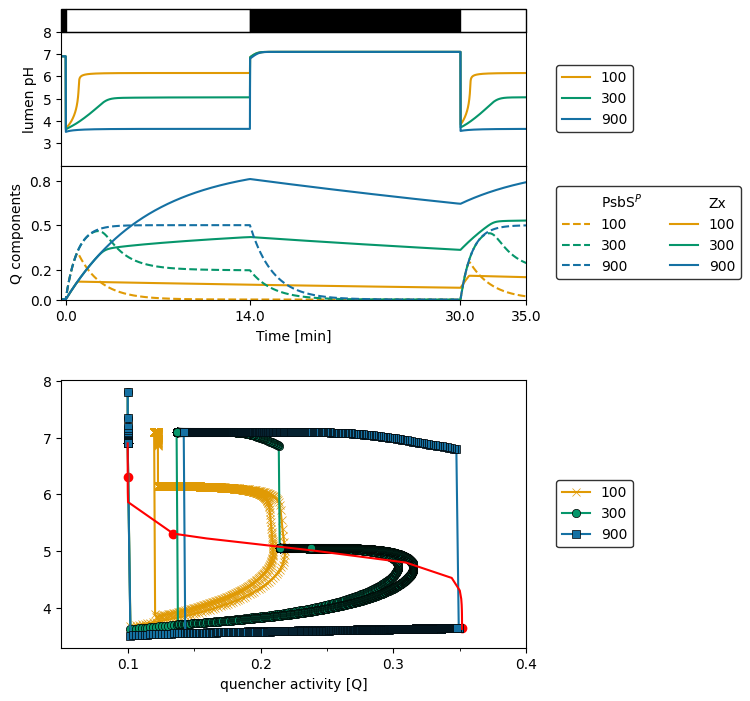

In [107]:
fig5_res, fig5_prtc = create_fig5_sim(
    model=Matuszynska2016(),
    pfd_str=pfd_str
)

create_fig5_plot(
    res=fig5_res,
    prtc=fig5_prtc,
    pfd_str=pfd_str,
    phlumen_str=phlumen_str,
    zx_str=zx_str,
    psbsp_str=psbsp_str,
    quencher_str=quencher_str
)

save_fig("5")

# Figure 6


In [162]:
def create_fig6_sim(
    model: Model,
    pfd_str: str
):
    model.update_parameter("gamma_2", 1)
    
    phase_1 = [30]
    phase_two = phase_intervals_linear(14*60, 20, 30)
    phase_three = phase_intervals_linear(16*60, 20, 30, num_steps=5, last_intervall=30)
    phase_four = phase_intervals_linear(5*60, 20, 30, last_intervall=0)
    
    sp_len = 0.8
    sp_val = 5000
    
    phase_prtc = []
    for phases, pfd_val in zip([phase_1, phase_two, phase_three, phase_four], [0, cpfd("Pothos", 100), 0, cpfd("Pothos", 100)], strict=False):
            for time in phases:
                phase_prtc.append((sp_len, {pfd_str: sp_val}))
                phase_prtc.append((time - sp_len, {pfd_str: pfd_val}))
    phase_prtc.append((5*60, {pfd_str: cpfd("Pothos", 100)}))
    
    pam_prtc = make_protocol(phase_prtc)
    s = Simulator(model)
    s.simulate_protocol(pam_prtc, time_points_per_step=1000)
    return s.get_result().unwrap_or_err().get_combined(), pam_prtc

def create_fig6_plot(
    res: pd.DataFrame,
    prtc: pd.DataFrame,
    data: dict[int, pd.DataFrame],
    pfd_str: str,
    fluorescence_str: str
):
    peaktimes, F, Fm, NPQ, Fo, Phi_psii = npq(
        fluo_results=res[fluorescence_str],
        peak_distance=250
    )
    
    fig6, axs = plt.subplots(nrows=2, figsize=(8, 6))
    
    axs[0].plot(F, color="#fa0100", label="Simulated trace")
    axs[1].plot(peaktimes, Phi_psii, color="#fa0100", marker='o', label="Simulation")
    
    data_df = data[100]
    data_df.index = data_df["Timedelta_mean"]
    axs[0].errorbar(data_df.index, data_df["Fm_rel_mean"], yerr=data_df["Fm_rel_std"], marker="^", color="black", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_M^'}$ measured", markersize=3.5)
    axs[0].errorbar(data_df.index, data_df['Ft_rel_mean'], yerr=data_df['Ft_rel_std'], marker="^", color="#0071ad", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_S}$ measured", markersize=3.5)
    axs[1].plot(data_df["Yield_mean"], marker="^", color="#0071ad", label=r"Experiment")

    axs[0].set_ylabel("Fluorescence (a.u.)")
    axs[0].set_ylim(0, 1)
    axs[0].set_yticks(np.linspace(0, 1, 6))
    axs[1].set_ylabel(r"$\Phi_{\mathrm{PSII}}$")
    axs[1].set_ylim(0, 0.9)
    axs[1].set_yticks(np.linspace(0, 0.8, 5))
    
    cleaned_prtc = prtc[prtc[pfd_str] != 5000]
    xmin = -2*60
    for ax in axs:
        ax.set_xlim(xmin, 36*60)
        ax.set_xlabel("Time (min)")
        xticks_labels = [0, 14, 30, 35]
        ax.set_xticks([i*60 for i in xticks_labels], labels=xticks_labels)
        
        ax.legend(frameon=True, edgecolor="black", loc="center", bbox_to_anchor=(0.2, 0.75))
        
        box_height = (ax.get_ylim()[-1] - ax.get_ylim()[0]) * 0.15
        rect_coords = []
        for idx, val in cleaned_prtc.iterrows():
            if val[pfd_str] == 0:
                color="black"
            else:
                color="white"
            
            new_x = min(idx.total_seconds(), ax.get_xlim()[1])
            if rect_coords == []:
                rect_coords.append({"color": color, "start": xmin, "end": new_x})
            elif rect_coords[-1]["color"] == color:
                rect_coords[-1]["end"] = new_x
            else:
                prior_idx = rect_coords[-1]["end"]
                rect_coords.append({"color": color, "start": prior_idx, "end": new_x})
        
        for i, rect in enumerate(rect_coords):
            box = ax.add_patch(Rectangle(
                (rect["start"], ax.get_ylim()[-1]),
                width=abs(rect["end"] - rect["start"]),
                height=box_height,
                facecolor = rect["color"],
                edgecolor="black",
                clip_on=False
            ))
    
    
    
    
    plt.tight_layout()
    
    return fig6, axs

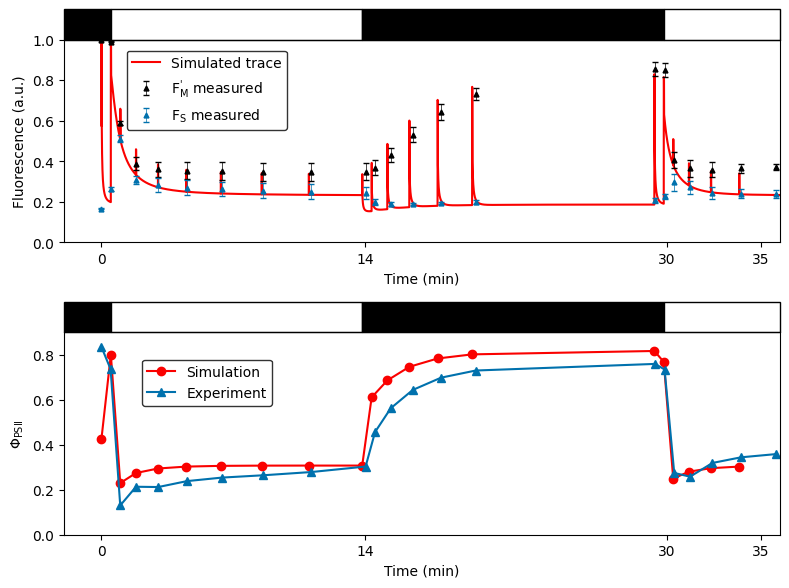

In [164]:
fig6_res, fig6_prtc = create_fig6_sim(
    model=Matuszynska2016(),
    pfd_str=pfd_str
)

create_fig6_plot(
    res=fig6_res,
    prtc=fig6_prtc,
    data=fig6_data,
    pfd_str=pfd_str,
    fluorescence_str=fluorescence_str
)

save_fig("6")